In [161]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import statistics as st
import seaborn as sns
import random as rd
import pandas as pd
import numpy as np

In [162]:
dataf = pd.read_csv("results/responses.csv")

In [163]:
def getBars(df,labels,value):
    bars = []
    for i in labels:
        bars.append(df.groupby("modal").get_group(i)[value].tolist())
    return bars

def plotBars(bars, ylabel, labels, fluxos, fname=None):
    # set width of bar
    barWidth = 0.2
    sns.set(style="white")

    patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]
    colors = ["#557f2d","#B8860B","#2d7f5e","#7f6d5f","#557f2d","#B8860B","#2d7f5e","#7f6d5f","#557f2d"]
    
    r1 = np.arange(len(bars[0]*2),step=2)
    for i in range(len(bars)): # bar number per flow

        plt.bar(r1, bars[i], color=colors[i], width=barWidth, edgecolor='white', label=labels[i],hatch=patterns[i])
        r1 = [x + barWidth for x in r1]
    
    # Add xticks on the middle of the group bars
    plt.xlabel('Routes', fontweight='bold')
    plt.ylabel(ylabel[0].upper() + ylabel[1:], fontweight='bold')
    plt.xticks([2*r + 4*barWidth for r in range(len(bars[0]))], fluxos)
 
    # Create legend & Show graphic
    plt.legend(loc="upper center",bbox_to_anchor=(0.33,1.25),fancybox=True,shadow=True,ncol=3)
    
    sns.despine()
    plt.rcParams["figure.figsize"] = (12,6)
    
    if fname != None: plt.savefig('data/results/plots/'+fname)
    plt.show()
    plt.close()

def plotBoxPlots(df,label,title,x,y,fname=None):
    plt.figure()
    plt.title(title)
    sns.boxplot(data=df,x=x,y=y)
    plt.xlabel(label)
    plt.ylabel("Modal")
    if fname != None: plt.savefig('data/results/plots/'+fname)
    plt.show()

def divide_range(min_val, max_val):

    divisions = np.linspace(min_val, max_val, 4)
    windows = [(divisions[i]) for i in range(3)]

    return windows

def determine_outliers(data: list):
    '''
    Função responsável por calcular quartis, amplitude interquartil e 
    retornar listas de outliers moderados e extremos de um conjunto de dados.
    '''
    sorted_data = sorted(data)

    Q = st.quantiles(sorted_data)
    A = Q[2] - Q[0]

    print(f"Quartis:\n{Q}\n")
    print(f"Amplitude interquartil: {A}\n")

    mod = []
    ext = []

    for i in data:
        if (i < Q[0]-1.5*A) or (i > Q[2]+1.5*A):
            mod.append(i)

        if (i < Q[0]-3*A) or (i > Q[2]+3*A):
            ext.append(i)

    print(f"{len(mod)} outlier(s) moderado(s):\n{mod}\n"\
    f"\n{len(ext)} outlier(s) extremo(s):\n{ext}")

    return mod, ext

In [164]:
## dataset filtering

rmLabels = ['Unnamed: 0','setID','modal']
ylabels = dataf.columns
ylabels = [ele for ele in ylabels if ele not in rmLabels]

labels = dataf['modal'].unique().tolist()
if "error" in labels: labels.remove("error")

removeID = dataf.loc[dataf['modal'] == 'error']['setID'].to_list() # remove setID with error
dataf_new = dataf.drop(dataf[dataf['setID'].isin(removeID)].index)

In [ ]:
## distance extreme outliers
"""
dist = dataf_new['distance'].to_list()

print('Quartis Distância:')
mod,ext = determine_outliers(dist)

print('\n\nOutliers:')

outlier = dataf_new.loc[dataf_new['distance'].isin(ext)]

print(dataf_new.shape)
dataf_new = dataf_new.drop(dataf_new[dataf_new['setID'].isin(outlier['setID'].unique())].index)
print(dataf_new.shape)

dataf_new.groupby("setID").count()
"""
#resultDf.to_csv(f'{resultFolder}/{resultFile}', index=False)

In [166]:
## separating data by range

dataf_median = dataf_new.groupby("setID")['distance'].median()
distance_wind = divide_range(min(dataf_median), max(dataf_median))

series_wind1 = dataf_median.loc[dataf_median <= distance_wind[1]]
series_wind2 = dataf_median.loc[(dataf_median > distance_wind[1]) & (dataf_median <= distance_wind[2])]
series_wind3 = dataf_median.loc[dataf_median > distance_wind[2]]

windows = [series_wind1,series_wind2,series_wind3]

print(distance_wind,dataf_new['distance'].max())

print([i.shape[0] for i in windows])

[4465.0, 15458.666666666666, 26452.333333333332] 67274.0
[67, 64, 6]


group 1
[67.0, 505.0, 566.0, 48.0]


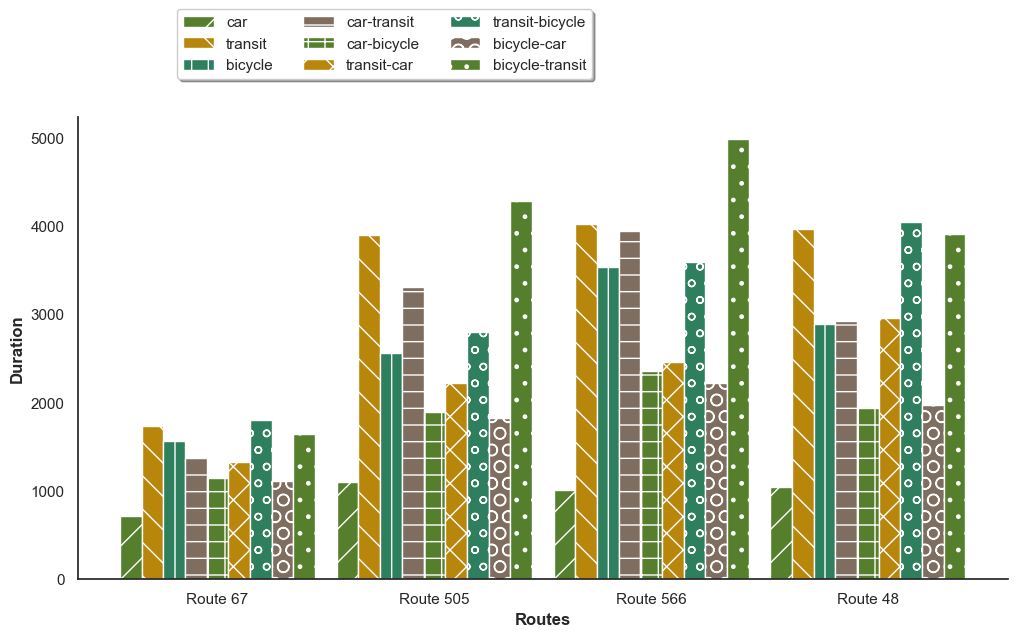

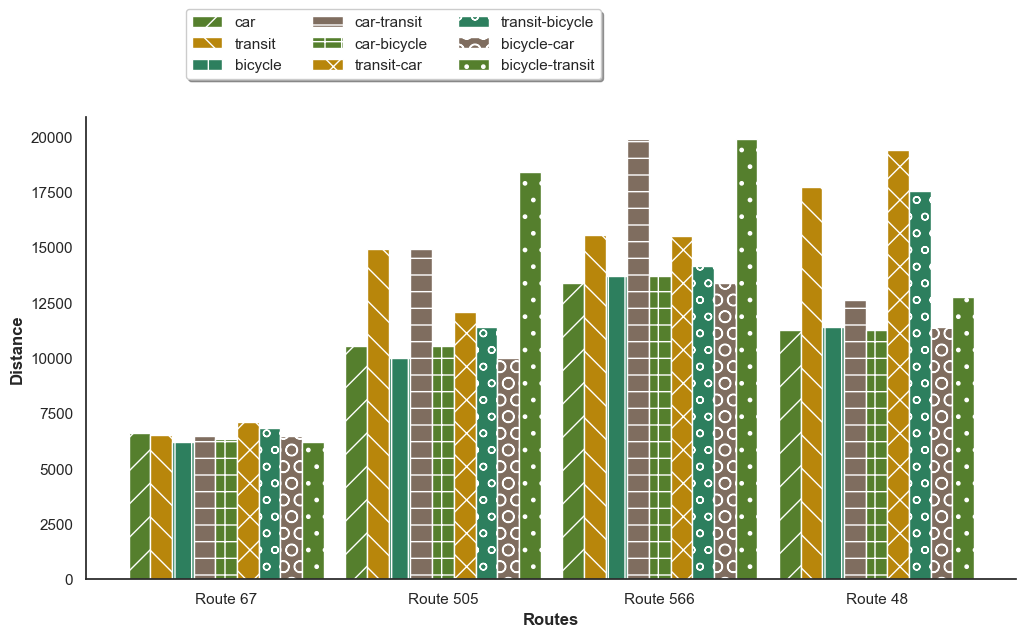

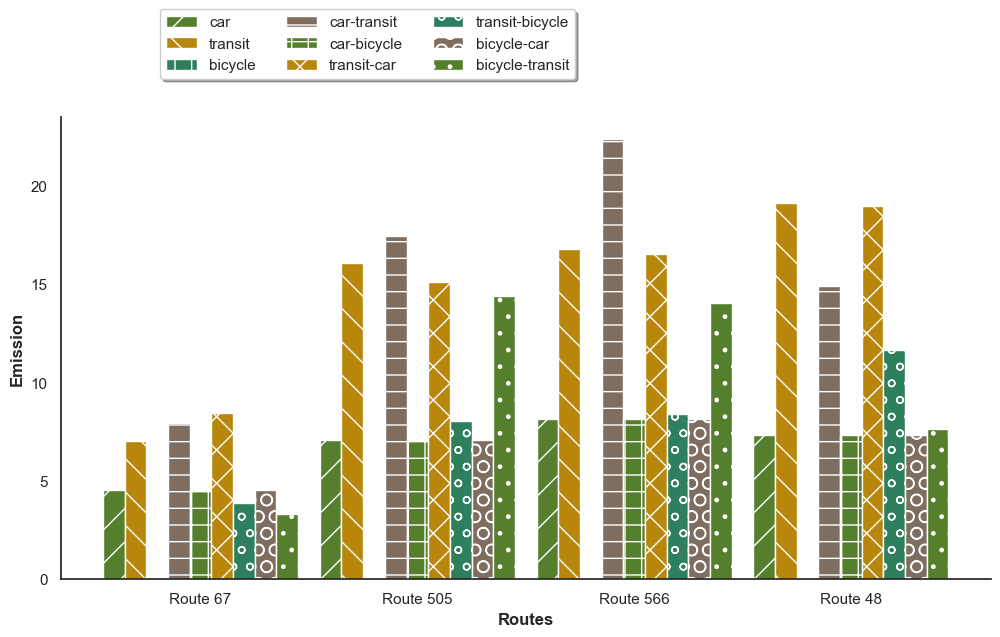

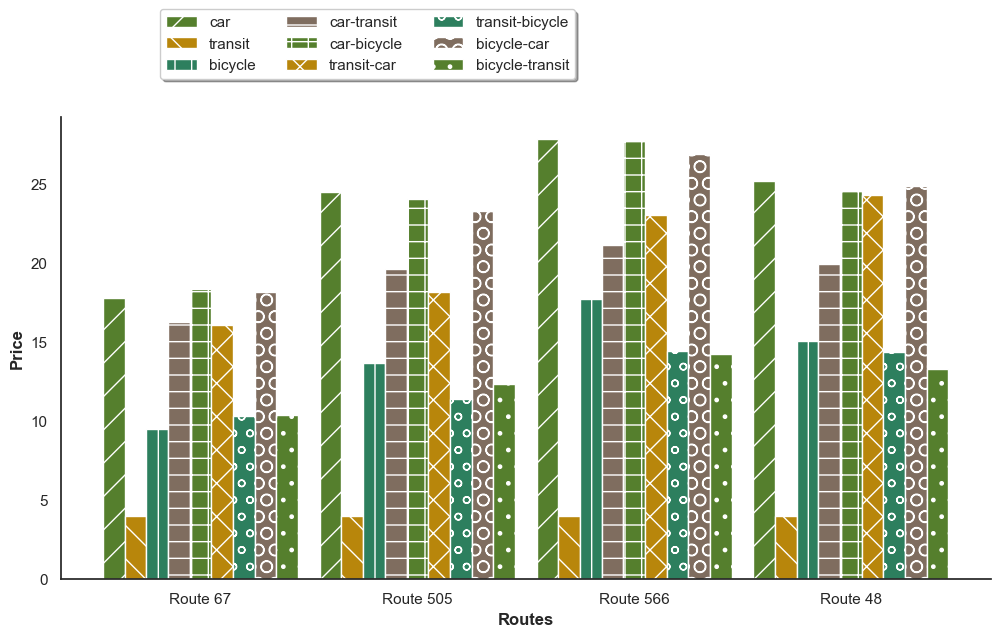

group 2
[272.0, 563.0, 584.0, 303.0]


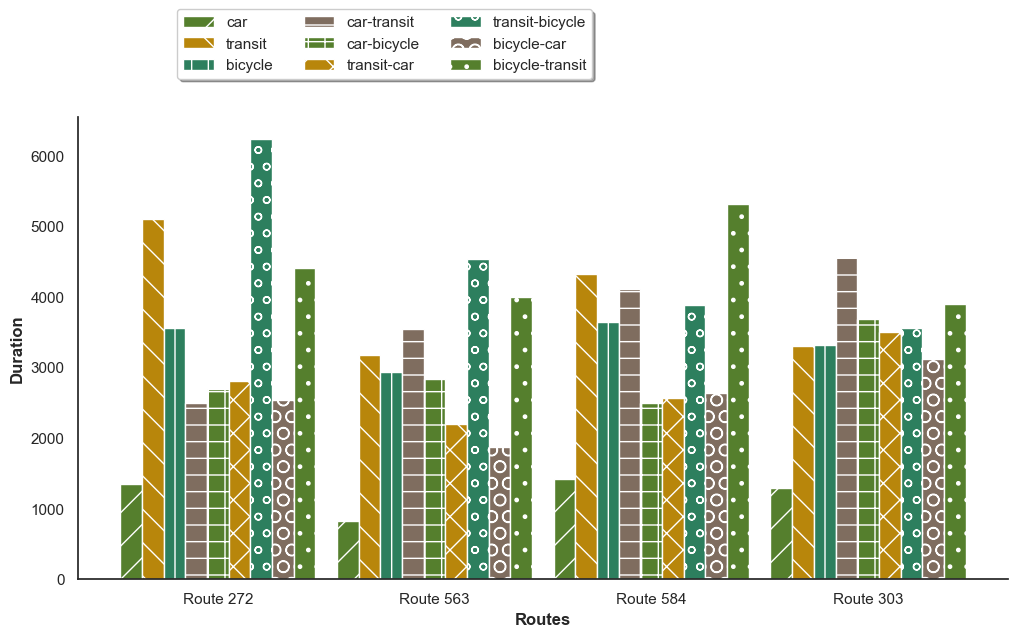

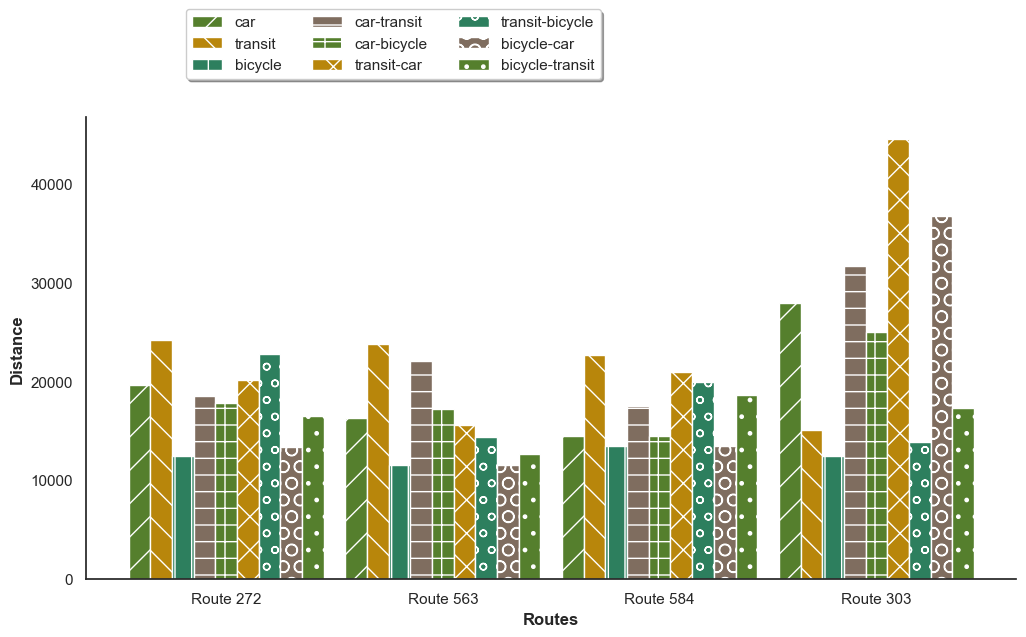

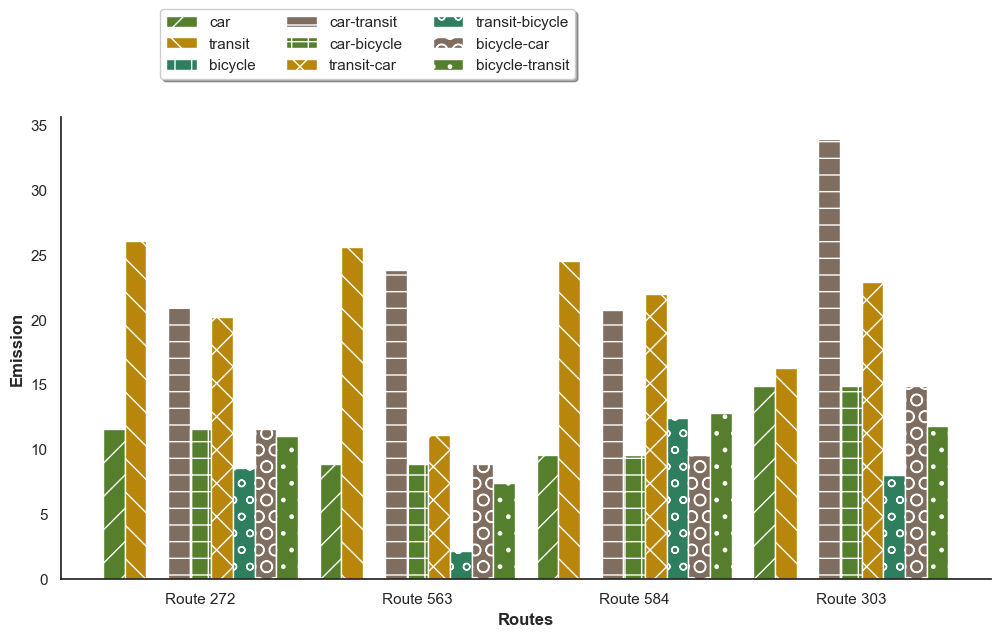

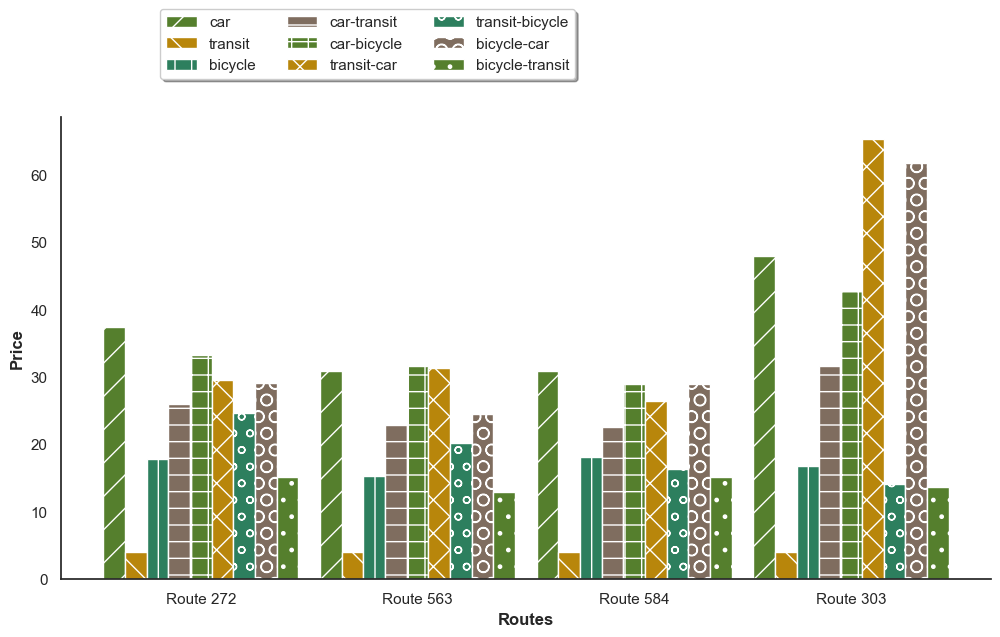

group 3
[588.0, 178.0, 171.0, 241.0]


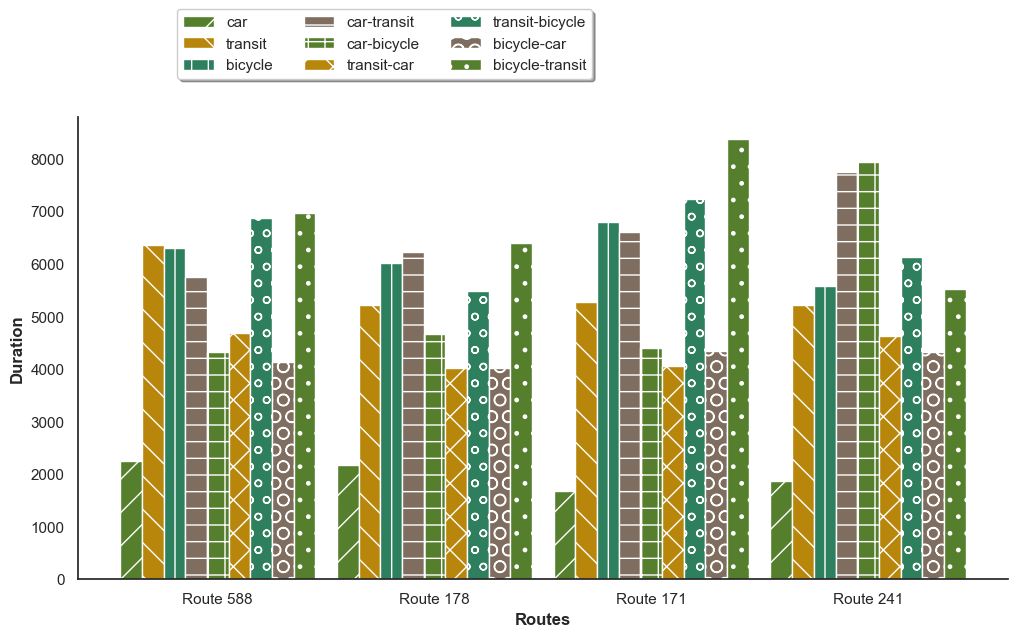

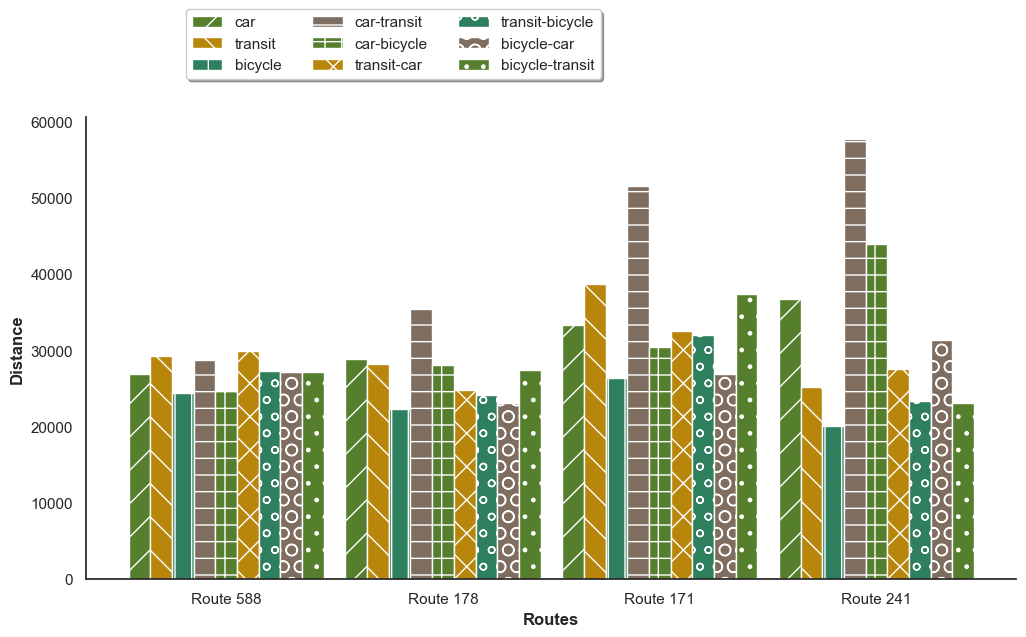

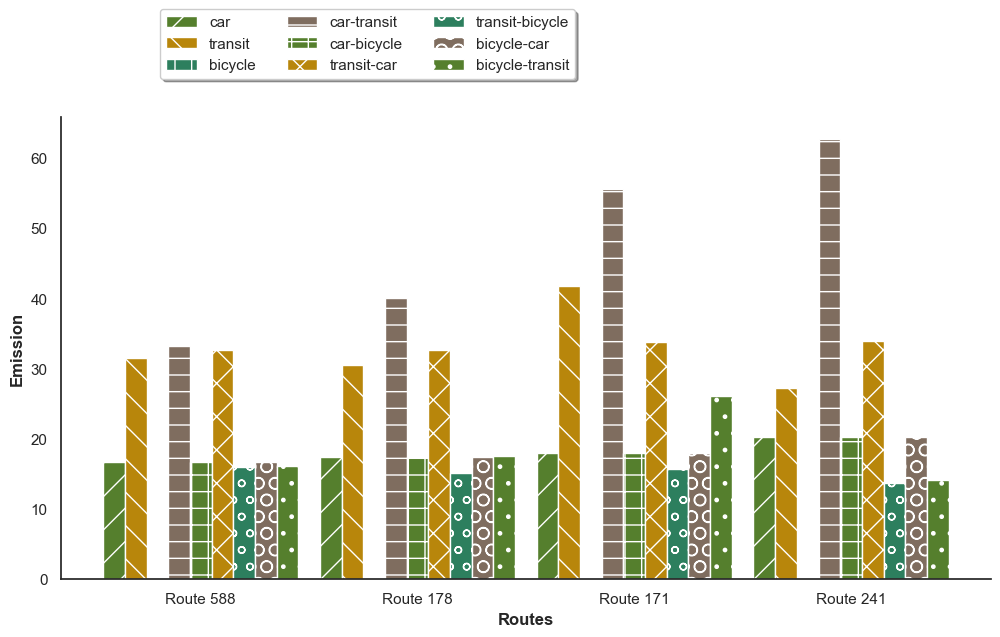

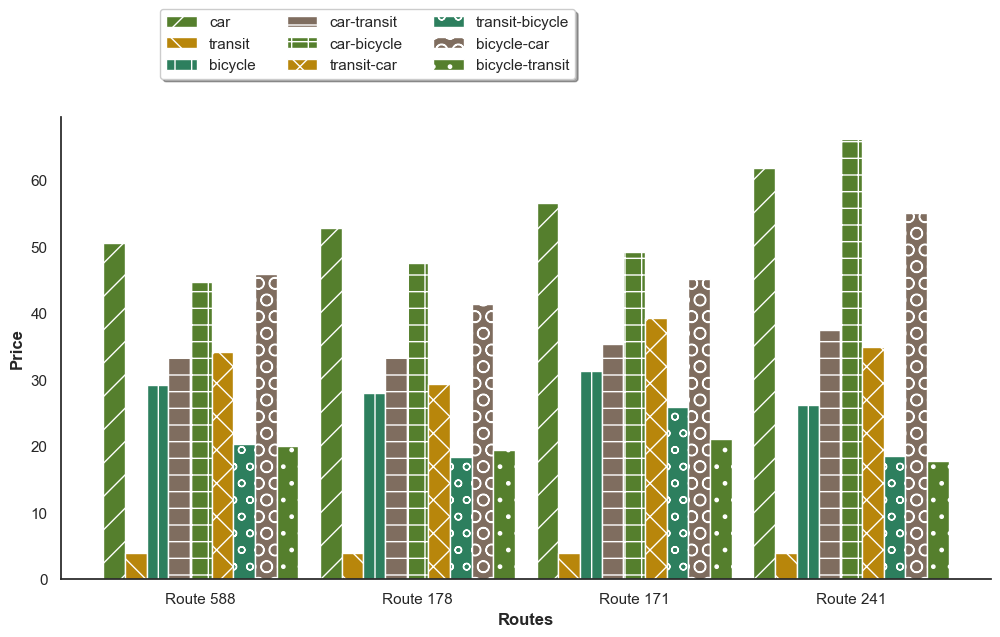

In [167]:
## barplot
rd.seed(10)

for j in range(len(distance_wind)):
    print("group",j+1)
    sampl = rd.sample(sorted(windows[j].index),4)
    print(sampl)

    group = dataf_new.loc[dataf_new['setID'].isin(sampl)]
    routes = list(map(lambda x: f"Route {int(x)}",sampl))
    for i in ylabels:
        bars = getBars(group,labels,i)
        plotBars(bars,i,labels,routes)
    

group 1


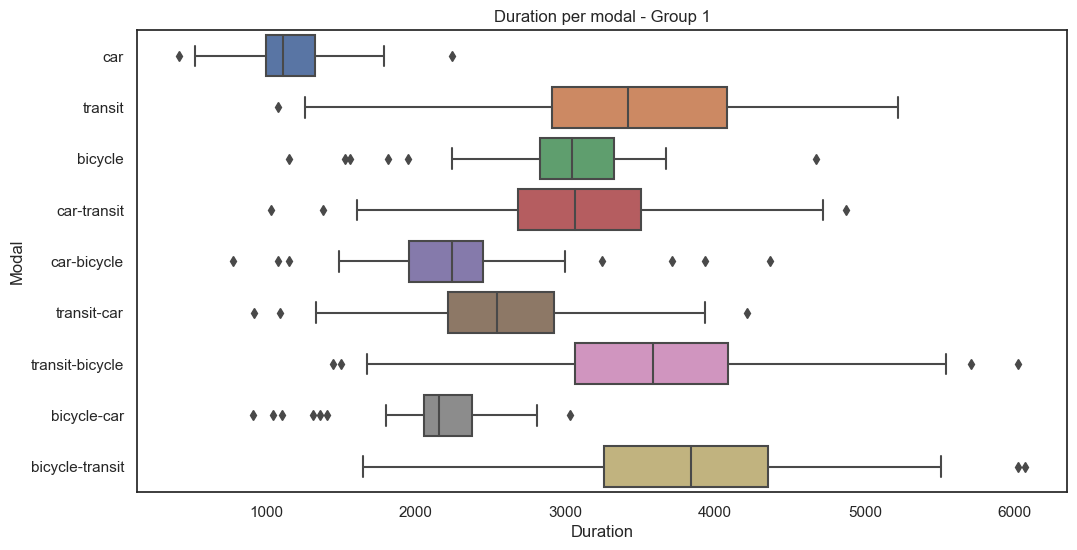

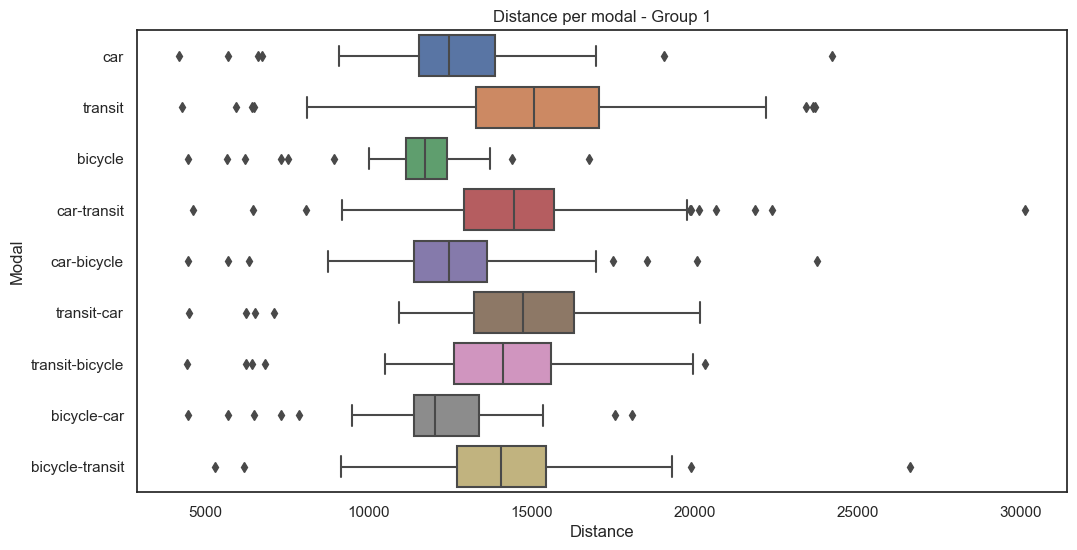

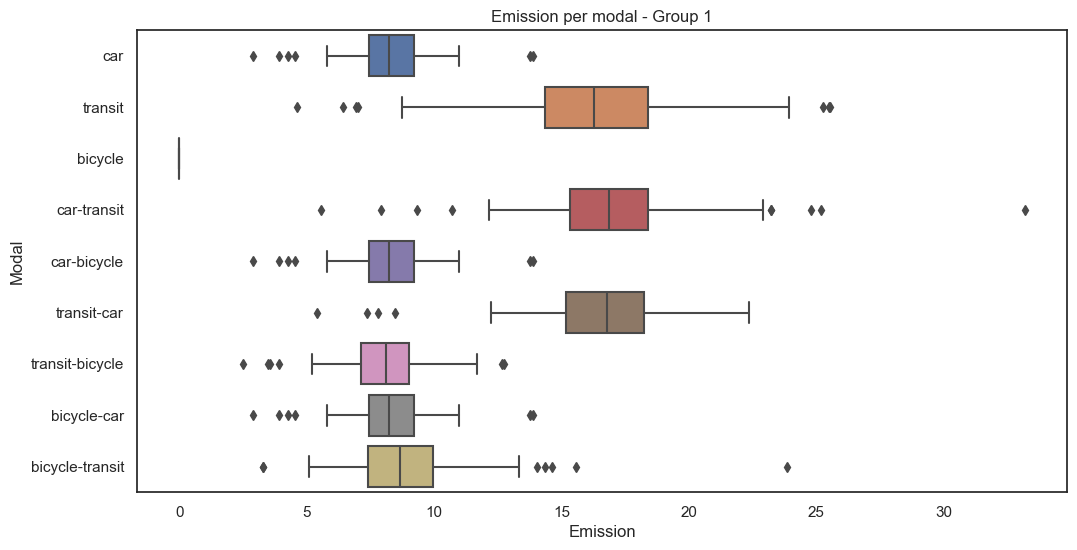

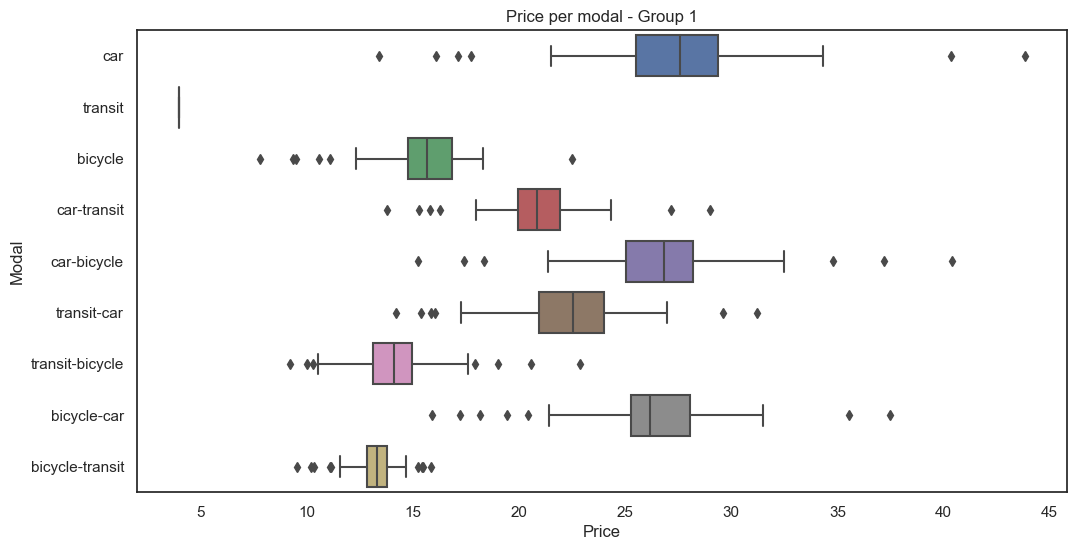

group 2


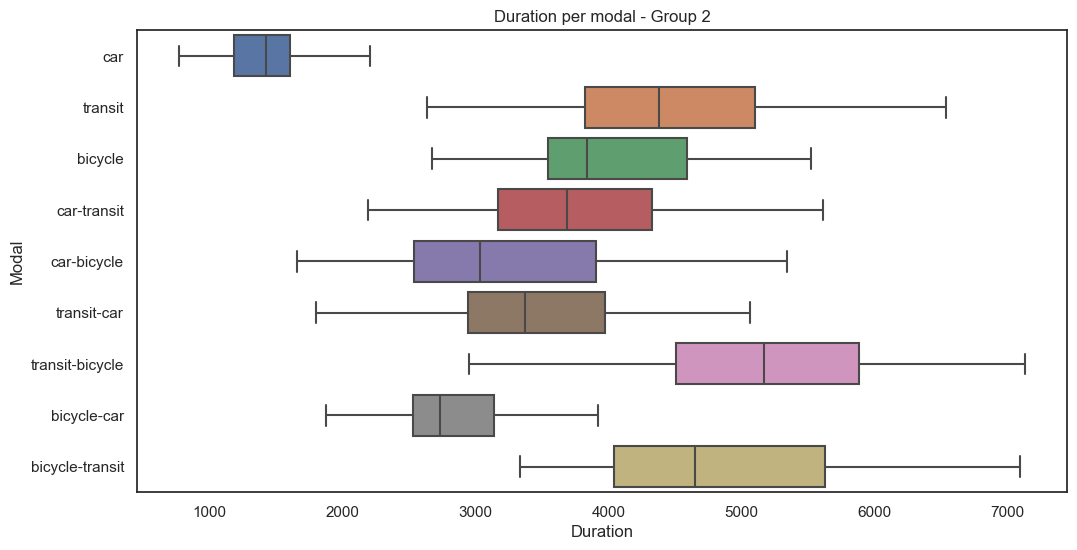

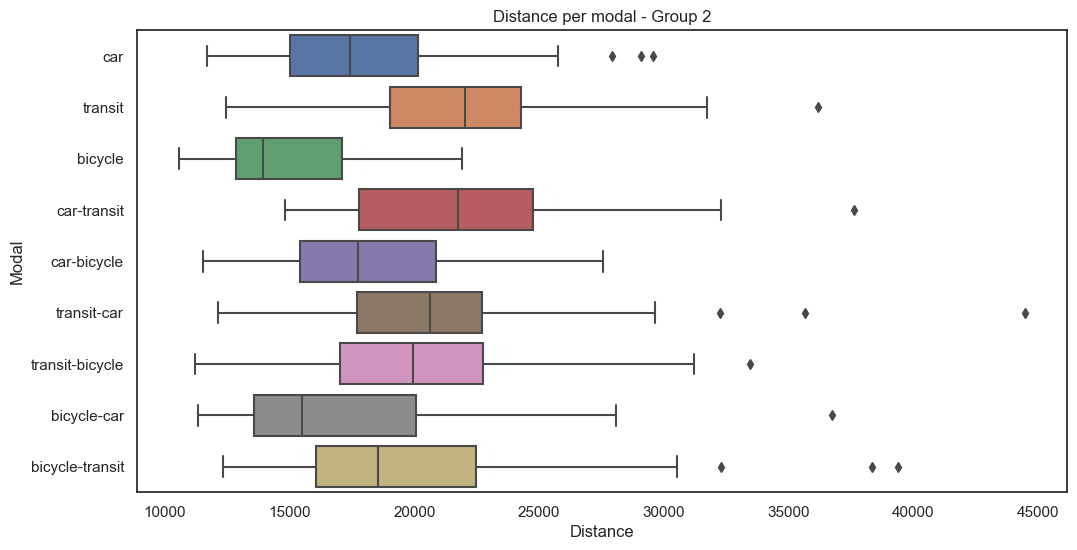

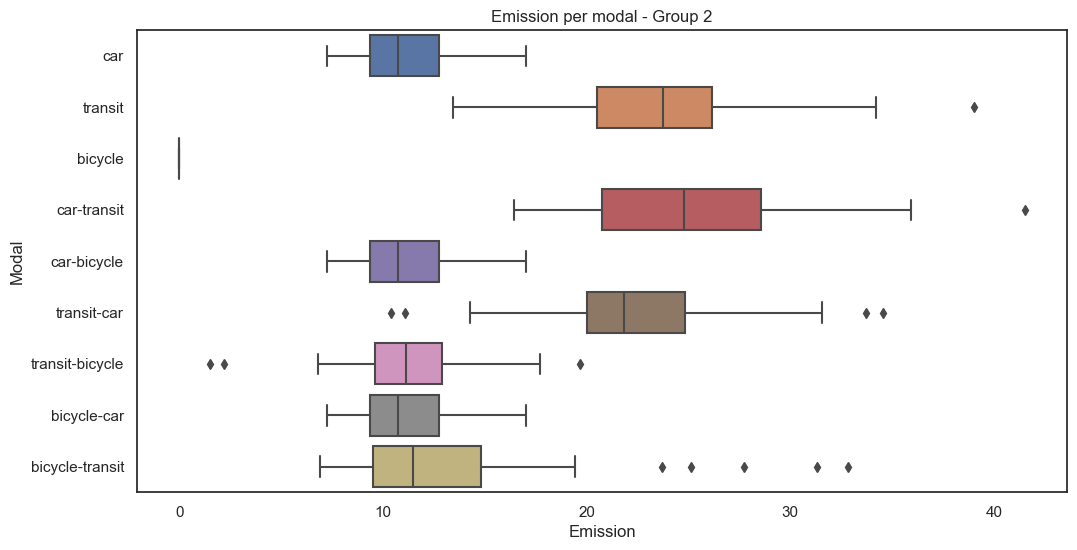

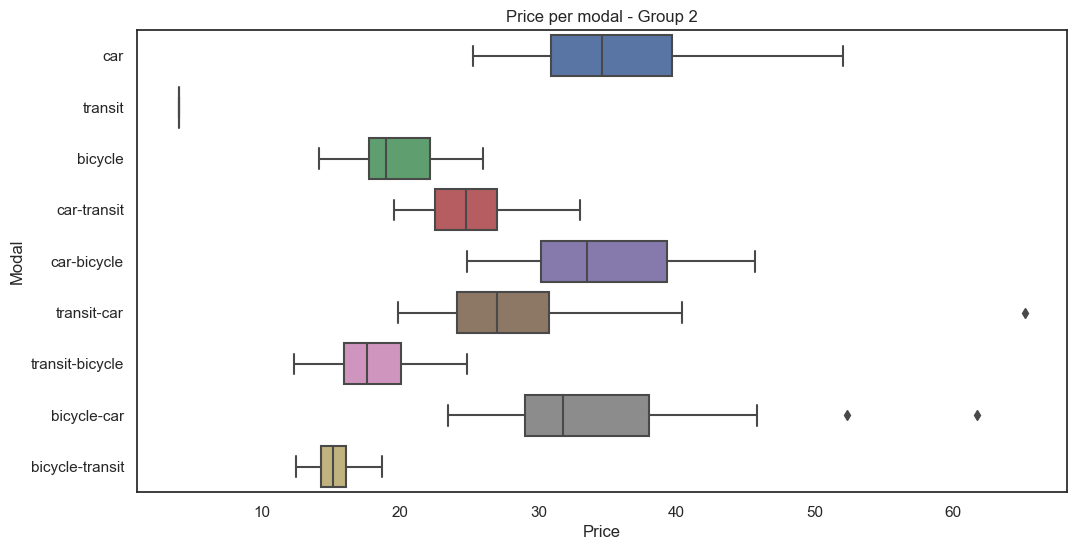

group 3


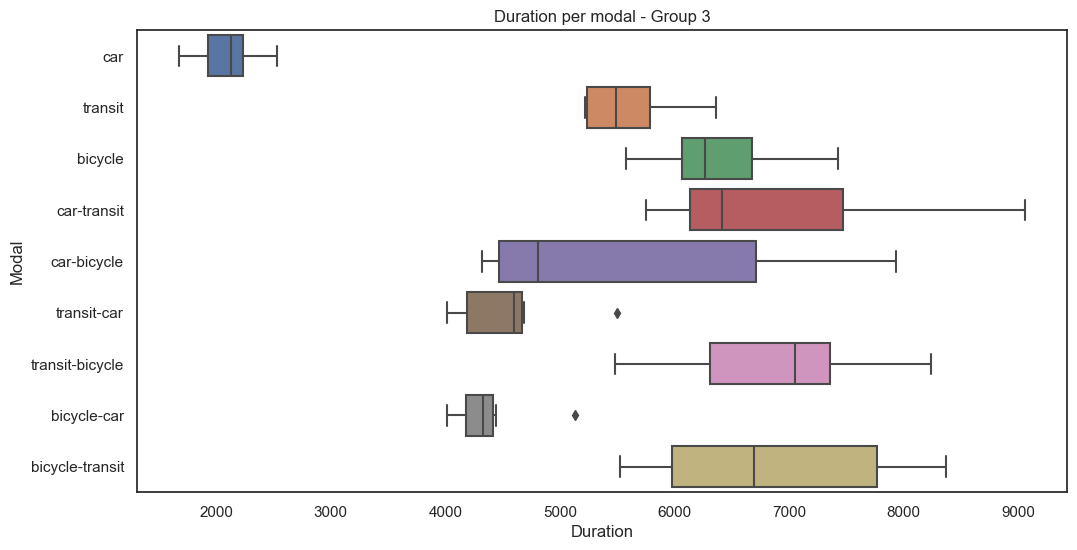

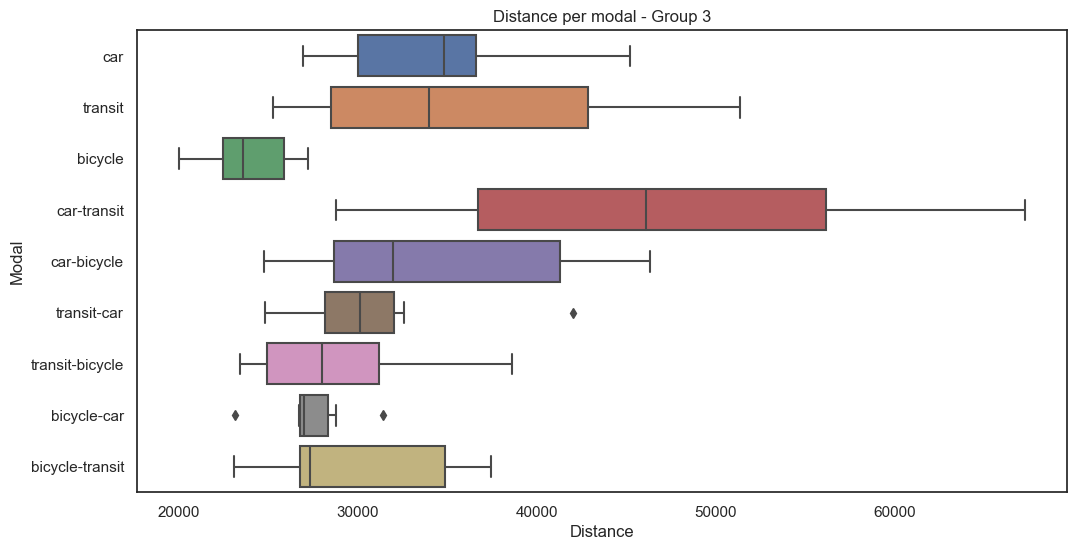

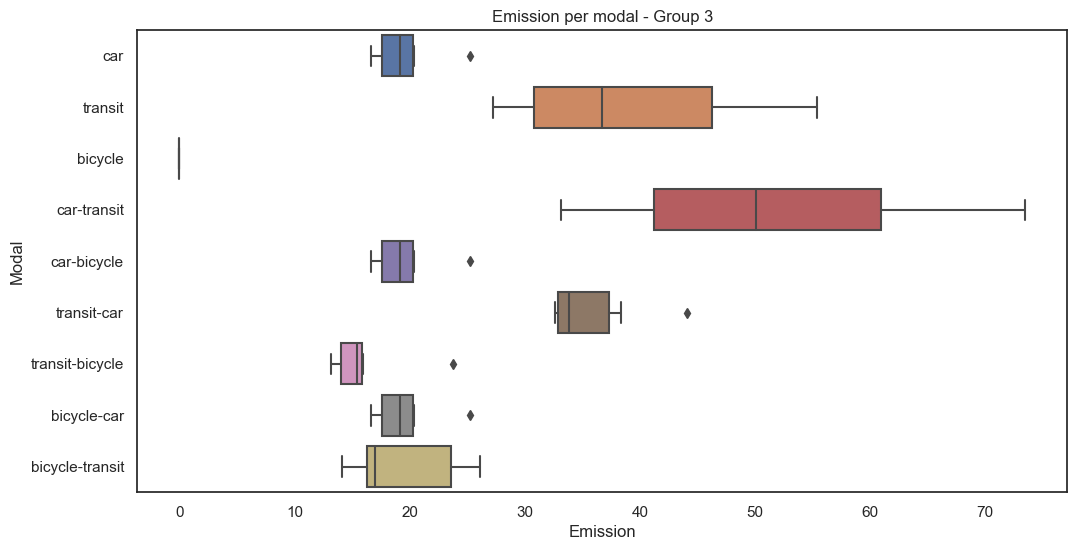

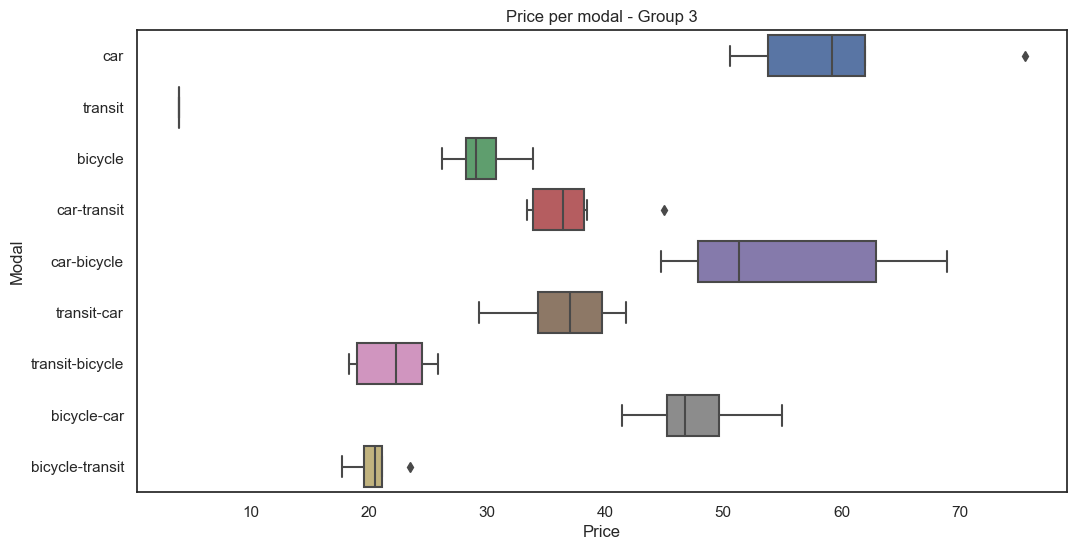

In [168]:
## boxplot
for j in range(len(distance_wind)):
    print("group",j+1)

    group = dataf_new.loc[dataf_new['setID'].isin(windows[j].index)]

    for i in range(len(ylabels)):
        upper = ylabels[i][0].upper() + ylabels[i][1:]
        
        plotBoxPlots(group,upper,f"{upper} per modal - Group {j+1}",ylabels[i],"modal")

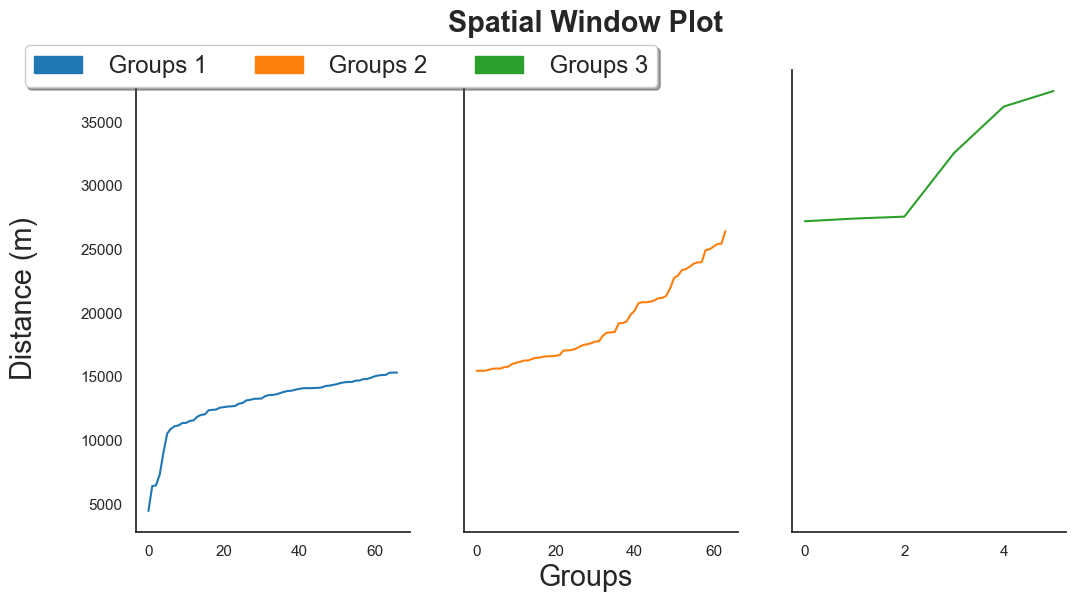

In [169]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=False,sharey=True,
                                    figsize=(12, 6))
values1 = sorted(series_wind1.values.tolist())
values2 = sorted(series_wind2.values.tolist())
values3 = sorted(series_wind3.values.tolist())

ax0.plot(range(len(values1)), values1,color="tab:blue",label='group 1',linestyle="solid")
ax1.plot(range(len(values2)), values2,color="tab:orange",label='group 2',linestyle="solid")
ax2.plot(range(len(values3)), values3,color="tab:green",label='group 3',linestyle="solid")

#ax0.set_xlabel("Window 1",fontsize="xx-large")
#ax1.set_xlabel("Window 2",fontsize="xx-large")
#ax2.set_xlabel("Window 3",fontsize="xx-large")

#ax0.set_xticks([])
#ax1.set_xticks([])
#ax2.set_xticks([])

leg_g1 = mpatches.Patch(color="tab:blue",label=" Groups 1")
leg_g2 = mpatches.Patch(color="tab:orange",label=" Groups 2")
leg_g3 = mpatches.Patch(color="tab:green",label=" Groups 3")

plt.legend(loc="upper right",
           bbox_to_anchor=(-0.45,1.08),
           ncol=3,
           fancybox=True,
           shadow=True,
           fontsize="x-large",
           handles = [leg_g1,leg_g2,leg_g3])


#ax0.set_title('Window 1')
#ax1.set_title('Window 2')
#ax2.set_title('Window 3')

#ax0.set_xticklabels([])

fig.suptitle('Spatial Window Plot',fontsize="xx-large",fontweight="bold")
fig.supxlabel("Groups",fontsize="xx-large")
fig.supylabel("Distance (m)",fontsize="xx-large")

sns.set_style("whitegrid", {'grid.linestyle': '--','axes.facecolor': '#F4F4F4'})

sns.despine(top=True,left=False)
plt.show()